In [3]:
import geopandas as gpd
import numpy as np
import shapely

In [4]:
N_SQUARES = 40
SQUARE_WIDTH = 0.2
N_CLASSES = 4

Create dummy data

<Axes: >

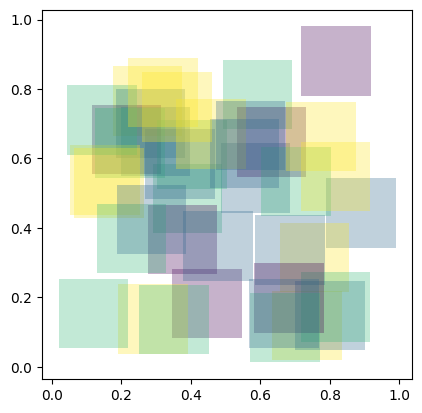

In [5]:
tl_corners = np.random.random((N_SQUARES, 2)) * (1 - SQUARE_WIDTH)
boxes = [shapely.box(tl[0], tl[1], tl[0] + SQUARE_WIDTH, tl[1] + SQUARE_WIDTH) for tl in tl_corners]
classes = np.random.randint(0, N_CLASSES, size=N_SQUARES)

classified_polygons = gpd.GeoDataFrame({"geometry": boxes, "classes": classes})
classified_polygons.plot("classes",alpha=0.3)

   counts                                           geometry
0     1.0  MULTIPOLYGON (((0.34737 0.0823, 0.34737 0.2658...
1     2.0  POLYGON ((0.34737 0.2823, 0.47698 0.2823, 0.47...


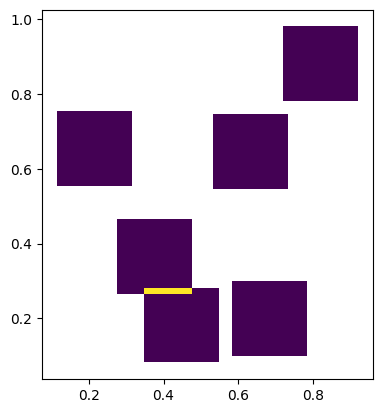

   counts                                           geometry
0     1.0  MULTIPOLYGON (((0.48703 0.44728, 0.48703 0.443...
1     2.0  MULTIPOLYGON (((0.37833 0.32499, 0.37833 0.447...
2     3.0  MULTIPOLYGON (((0.70097 0.24731, 0.76869 0.247...


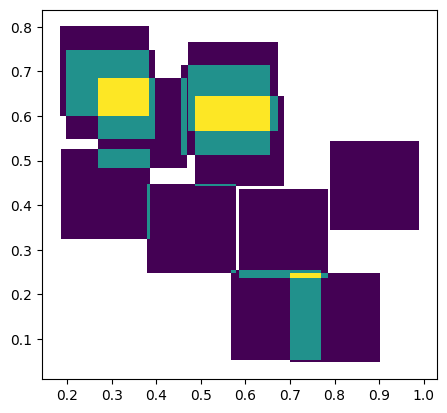

   counts                                           geometry
0     1.0  MULTIPOLYGON (((0.45229 0.23614, 0.45229 0.036...
1     2.0  MULTIPOLYGON (((0.77144 0.21246, 0.77144 0.071...
2     3.0  POLYGON ((0.30419 0.5847, 0.3253 0.5847, 0.325...


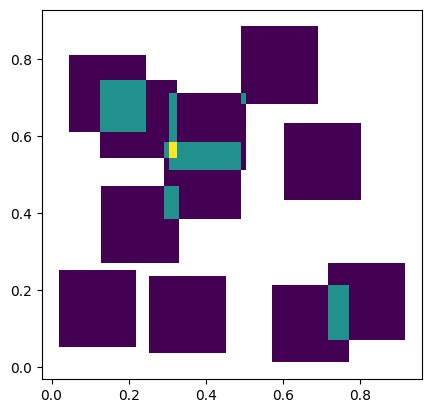

   counts                                           geometry
0     1.0  MULTIPOLYGON (((0.39124 0.23804, 0.39124 0.038...
1     2.0  MULTIPOLYGON (((0.65638 0.21422, 0.65638 0.219...
2     3.0  MULTIPOLYGON (((0.37536 0.68926, 0.37536 0.665...
3     4.0  POLYGON ((0.35841 0.77021, 0.37536 0.77021, 0....


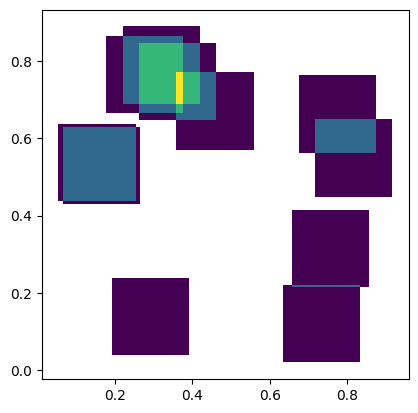

In [ ]:
import matplotlib.pyplot as plt
def merge_classified_polygons(classified_polygons, class_column=None):
    grouped = {k[0]:v for k, v in classified_polygons.groupby([class_column])}
    for k, v in grouped.items():
        v.drop("classes", axis=1, inplace=True)
        v["counts"] = 1

        overlay = v.iloc[0:1]

        for i in range(1, len(v)):
            overlay = gpd.overlay(overlay, v.iloc[i:i+1], how="union")
            overlay.fillna(0, inplace=True)
            overlay["counts"] = overlay["counts_1"] + overlay["counts_2"]
            overlay.drop(["counts_1", "counts_2"], axis=1, inplace=True)
        overlay.plot("counts")
        overlay = overlay.dissolve("counts", as_index=False)
        print(overlay)
        plt.show()
    # Split by class
    # Group each class and count the number of contributions

merge_classified_polygons(classified_polygons=classified_polygons, class_column="classes")